In [1]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial

In [2]:
def forward_transform_with_shadow(n, xrange, object_array, reflectivity_array, field_of_view, wavelength, samplerate):
    Object = object_array
    Reflectivity = reflectivity_array
    N = np.size(Reflectivity)
    FOV = field_of_view
    l = wavelength
    sample_rate = samplerate
    
    ## Here to the end of the cell is going through the transform and inverse by hand w/ the "shadow function"
    newx = xrange
    OneD_transform = np.empty(N,dtype=np.complex)
    OneD_forward_integrand = np.empty(N,dtype=np.complex)
    deltak = 1/FOV
    heightdiff = np.diff(Object)
    h = np.where(heightdiff != 0)[0]
    
    shadow_function = np.ones(N)
    if n > 0:
        theta = 2*np.arcsin(n*wavelength*deltak/2)
        d = heightdiff*np.tan(theta/2)
        for i in range(np.size(h)):
            dindex = int(np.round(d[h[i]]/sample_rate))
            if heightdiff[h[i]] > 0:
                if i == 0:
                    shadow_function[max(0,h[i]-dindex):h[i]+1] = 0.0
                elif h[i]-dindex > h[i-1]:
                    shadow_function[max(0,h[i]-dindex):h[i]+1] = 0.0
                elif h[i]-dindex < h[i-1]:
                    if heightdiff[h[i-1]] > 0:
                        dindex = int(np.round((heightdiff[h[i]]+heightdiff[h[i-1]])*np.tan(theta/2)/sample_rate))
                        shadow_function[max(0,h[i]-dindex):h[i]+1] = 0.0 
                    elif heightdiff[h[i-1]] < 0:
                        shadow_function[h[i-1]:h[i]+1] = 0.0
            elif heightdiff[h[i]] < 0:
                if i == np.size(h)-1:
                    shadow_function[h[i]:min(N,h[i]-dindex+1)] = 0.0
                elif h[i]-dindex < h[i+1]:
                    shadow_function[h[i]:min(N,h[i]-dindex+1)] = 0.0
                elif h[i]-dindex > h[i+1]:
                    if heightdiff[h[i+1]] > 0:
                        shadow_function[h[i]:h[i+1]+1] = 0.0
                    elif heightdiff[h[i+1]] < 0:
                        dindex = int(np.round((heightdiff[h[i]]+heightdiff[h[i+1]])*np.tan(theta/2)/sample_rate))
                        shadow_function[h[i]:min(N,h[i]-dindex+1)] = 0.0

    OneD_forward_integrand = Reflectivity*np.exp(n*(-1j)*newx*2*np.pi/N)*shadow_function
    OneD_transform = np.sum(OneD_forward_integrand)

    
    return OneD_transform

if __name__=="__main__":
    p = Pool()

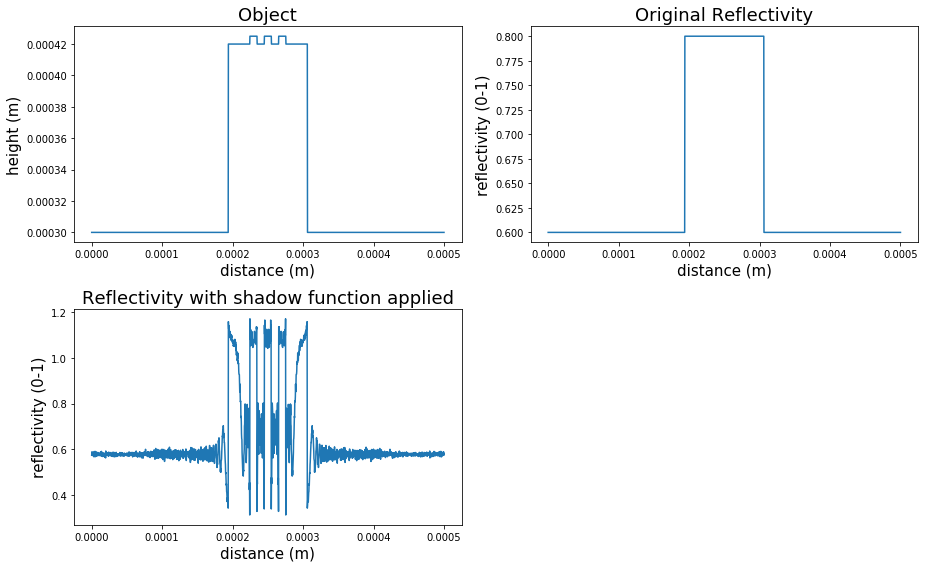

In [4]:
## setting up the range and the field of view (FOV)
N = 1800
FOV = 5e-4
x = np.linspace(0,FOV,N)
x_range = np.arange(N)
sample_rate = x[2] - x[1]
l = 532e-9

## Setting up the reflectivity as a function of x. This is what we'll be taking the transform of.
Reflectivity = np.ones(N)*(6/10)
Reflectivity[int(round(19*N/49)):int(round(30*N/49))] = 0.8
Object = np.ones(N)*(6/10)*FOV
Object[int(round(19*N/49)):int(round(30*N/49))] = 0.84*FOV
Object[int(round(22*N/49)):int(round(23*N/49))] = 0.85*FOV
Object[int(round(24*N/49)):int(round(25*N/49))] = 0.85*FOV
Object[int(round(26*N/49)):int(round(27*N/49))] = 0.85*FOV
# Object = Object*FOV

## Mapping the trasnform function to a simple array for optimization purpposes
IPSII = np.asarray(p.map(partial(forward_transform_with_shadow, xrange = x_range, object_array=Object, reflectivity_array=Reflectivity, field_of_view=FOV, wavelength=l, samplerate=sample_rate),range(N)))

tolerance = 1e-10
IPSII.real[abs(IPSII.real) < tolerance] = 0.0
IPSII.imag[abs(IPSII.imag) < tolerance] = 0.0


## just plotting here on out
plt.subplots(figsize=(13,8))
plt.subplot(2,2,1)
plt.title("Object", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("height (m)", fontsize=15)
plt.plot(x,Object)

plt.subplot(2,2,2)
plt.title("Original Reflectivity", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,Reflectivity)

plt.subplot(2,2,3)
plt.title("Reflectivity with shadow function applied", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,np.fft.ifft((IPSII)).real)
plt.tight_layout()
plt.show()

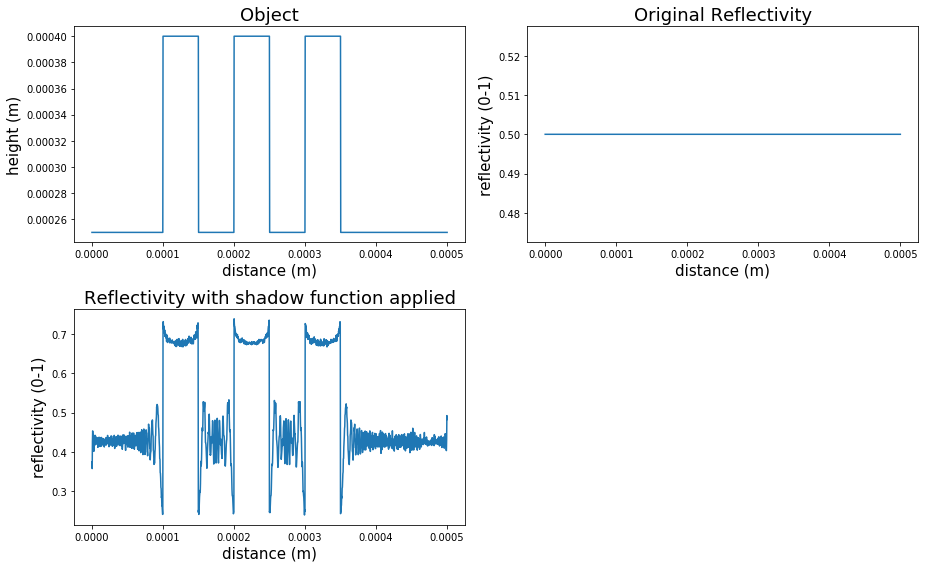

In [5]:
## setting up the range and the field of view (FOV)
N = 1500
FOV = 5e-4
x = np.linspace(0,FOV,N)
x_range = np.arange(N)
sample_rate = x[2] - x[1]
l = 532e-9

## Setting up the reflectivity as a function of x. This is what we'll be taking the transform of.
Object = np.ones(N)*(5/10)
Object[int(round(2*N/10)):int(round(3*N/10))] = 0.8
Object[int(round(4*N/10)):int(round(5*N/10))] = 0.8
Object[int(round(6*N/10)):int(round(7*N/10))] = 0.8
Object = Object*FOV
Reflectivity = np.ones(N)*(5/10)


## Mapping the trasnform function to a simple array for optimization purpposes
IPSII = np.asarray(p.map(partial(forward_transform_with_shadow, xrange = x_range, object_array=Object, reflectivity_array=Reflectivity, field_of_view=FOV, wavelength=l, samplerate=sample_rate),range(N)))

tolerance = 1e-10
IPSII.real[abs(IPSII.real) < tolerance] = 0.0
IPSII.imag[abs(IPSII.imag) < tolerance] = 0.0


## just plotting here on out
plt.subplots(figsize=(13,8))
plt.subplot(2,2,1)
plt.title("Object", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("height (m)", fontsize=15)
plt.plot(x,Object)

plt.subplot(2,2,2)
plt.title("Original Reflectivity", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,Reflectivity)

plt.subplot(2,2,3)
plt.title("Reflectivity with shadow function applied", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,np.fft.ifft((IPSII)).real)
plt.tight_layout()
plt.show()

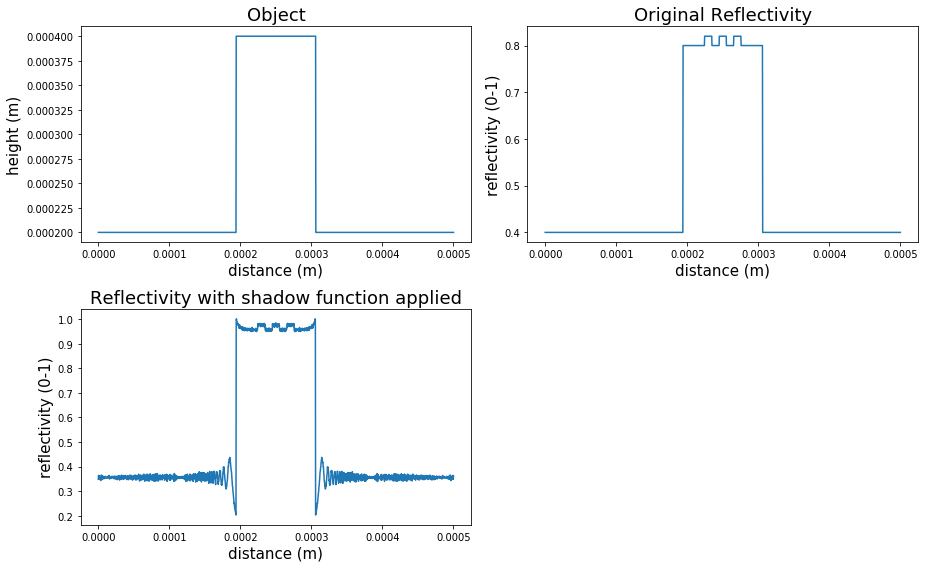

In [6]:
## setting up the range and the field of view (FOV)
N = 1500
FOV = 5e-4
x = np.linspace(0,FOV,N)
x_range = np.arange(N)
sample_rate = x[2] - x[1]
l = 532e-9

## Setting up the reflectivity as a function of x. This is what we'll be taking the transform of.
Reflectivity = np.ones(N)*(4/10)
Reflectivity[int(round(19*N/49)):int(round(30*N/49))] = 0.8
Object = Reflectivity*FOV
Reflectivity[int(round(22*N/49)):int(round(23*N/49))] = 0.82
Reflectivity[int(round(24*N/49)):int(round(25*N/49))] = 0.82
Reflectivity[int(round(26*N/49)):int(round(27*N/49))] = 0.82


## Mapping the trasnform function to a simple array for optimization purpposes
IPSII = np.asarray(p.map(partial(forward_transform_with_shadow, xrange = x_range, object_array=Object, reflectivity_array=Reflectivity, field_of_view=FOV, wavelength=l, samplerate=sample_rate),range(N)))

tolerance = 1e-10
IPSII.real[abs(IPSII.real) < tolerance] = 0.0
IPSII.imag[abs(IPSII.imag) < tolerance] = 0.0


## just plotting here on out
plt.subplots(figsize=(13,8))
plt.subplot(2,2,1)
plt.title("Object", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("height (m)", fontsize=15)
plt.plot(x,Object)

plt.subplot(2,2,2)
plt.title("Original Reflectivity", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,Reflectivity)

plt.subplot(2,2,3)
plt.title("Reflectivity with shadow function applied", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,np.fft.ifft((IPSII)).real)
plt.tight_layout()
plt.show()

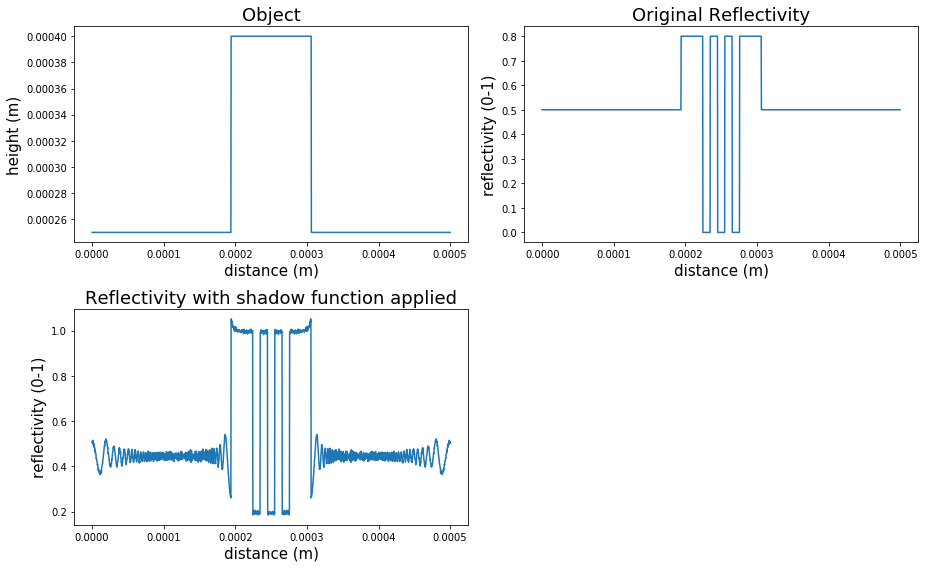

In [7]:
## setting up the range and the field of view (FOV)
N = 1500
FOV = 5e-4
x = np.linspace(0,FOV,N)
x_range = np.arange(N)
sample_rate = x[2] - x[1]
l = 532e-9

## Setting up the reflectivity as a function of x. This is what we'll be taking the transform of.
Reflectivity = np.ones(N)*(5/10)
Reflectivity[int(round(19*N/49)):int(round(30*N/49))] = 0.8
Object = Reflectivity*FOV
Reflectivity[int(round(22*N/49)):int(round(23*N/49))] = 0
Reflectivity[int(round(24*N/49)):int(round(25*N/49))] = 0
Reflectivity[int(round(26*N/49)):int(round(27*N/49))] = 0


## Mapping the trasnform function to a simple array for optimization purpposes
IPSII = np.asarray(p.map(partial(forward_transform_with_shadow, xrange = x_range, object_array=Object, reflectivity_array=Reflectivity, field_of_view=FOV, wavelength=l, samplerate=sample_rate),range(N)))

tolerance = 1e-10
IPSII.real[abs(IPSII.real) < tolerance] = 0.0
IPSII.imag[abs(IPSII.imag) < tolerance] = 0.0


## just plotting here on out
plt.subplots(figsize=(13,8))
plt.subplot(2,2,1)
plt.title("Object", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("height (m)", fontsize=15)
plt.plot(x,Object)

plt.subplot(2,2,2)
plt.title("Original Reflectivity", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,Reflectivity)

plt.subplot(2,2,3)
plt.title("Reflectivity with shadow function applied", fontsize=18)
plt.xlabel("distance (m)", fontsize=15)
plt.ylabel("reflectivity (0-1)", fontsize=15)
plt.plot(x,np.fft.ifft((IPSII)).real)
plt.tight_layout()
plt.show()